In [1]:
import pseudo_R2
import pandas as pd
import numpy as np

import scipy.optimize
import scipy.stats as stats


In [2]:
def calc_pR2(sites, mutations, rates, distribution = None, polymorphism = True):
    bin_p = sites / np.sum(sites)

    # Use a Poisson link to scale rates to the probability of observing a mutation
    # This is relevant if analyzing population data where recurrent mutation is likely
    
    if polymorphism:    
        def poisson_link(x):
            return -np.sum(stats.binom.logpmf(k=mutations,
                                              n=sites,
                                              p=(1 - np.exp(-x * rates))))
        # Find a non-awful starting place for optimization
        # Replace with ML estimate at some point
        x0 = np.array([-np.log(0.99) / np.max(rates)])
        scaling_fit = scipy.optimize.minimize(poisson_link, x0, method='Nelder-Mead',
                                              options={'xatol': 1e-3, 'disp': False})
        scaling_factor = scaling_fit.x[0]

        mut_p = 1 - np.exp(-scaling_factor * rates)
    else:
        def poisson_link(x):
            return -np.sum(stats.binom.logpmf(k=mutations,
                                              n=sites,
                                              p=x * rates))
        # Find a non-awful starting place for optimization
        # Replace with ML estimate at some point
        x0 = np.array([-np.log(0.99) / np.max(rates)])
        scaling_fit = scipy.optimize.minimize(poisson_link, x0, method='Nelder-Mead',
                                              options={'xatol': 1e-3, 'disp': False})
        scaling_factor = scaling_fit.x[0]

        mut_p = scaling_factor * rates
            
    # Calculate pseudo-R2 for the observed data
    if distribution is None:
        e_ll = pseudo_R2.exp_likelihood_model(mut_p, bin_p)
        e_ll_null = pseudo_R2.exp_likelihood_null(mut_p, bin_p)
    else:
        sites_d = distribution[0]
        mutations_d = distribution[1]
        rates_d = distribution[2]
        
        bin_p_d = sites_d / np.sum(sites_d)

        
        if polymorphism:    
            def poisson_link(x):
                return -np.sum(stats.binom.logpmf(k=mutations_d,
                                                  n=sites_d,
                                                  p=(1 - np.exp(-x * rates_d))))
            # Find a non-awful starting place for optimization
            # Replace with ML estimate at some point
            x0 = np.array([-np.log(0.99) / np.max(rates_d)])
            scaling_fit = scipy.optimize.minimize(poisson_link, x0, method='Nelder-Mead',
                                                  options={'xatol': 1e-3, 'disp': False})
            scaling_factor = scaling_fit.x[0]

            mut_p_distribution = 1 - np.exp(-scaling_factor * rates_d)
        
        else:
            def poisson_link(x):
                return -np.sum(stats.binom.logpmf(k=mutations_d,
                                                  n=sites_d,
                                                  p=x * rates_d))
            # Find a non-awful starting place for optimization
            # Replace with ML estimate at some point
            x0 = np.array([-np.log(0.99) / np.max(rates_d)])
            scaling_fit = scipy.optimize.minimize(poisson_link, x0, method='Nelder-Mead',
                                                  options={'xatol': 1e-3, 'disp': False})
            scaling_factor = scaling_fit.x[0]

            mut_p_distribution = scaling_factor * rates_d
        
        e_ll = pseudo_R2.exp_likelihood_model(mut_p_distribution, bin_p_d)
        e_ll_null = pseudo_R2.exp_likelihood_null(mut_p_distribution, bin_p_d)
        
    a_ll = pseudo_R2.avg_likelihood_sample(sites, mutations, mut_p)
#     a_ll_null = pseudo_R2.null_likelihood_sample(sites, mutations, mut_p, bin_p)

    
    max_R2 = pseudo_R2.calculate_R2(e_ll, e_ll_null)
    R2 = pseudo_R2.calculate_R2(a_ll, e_ll_null)
    pR2 = R2 / max_R2
    return max_R2, R2, pR2

In [6]:
mu_list = ["mu", "Carlson_rate", "gnomAD_rate"]

In [23]:
def run_pR2_sampling_persite(polymorphic):
    _bootstrap = 1000

    max_R2_s_s = []
    R2_s_s = []
    pR2_s_s = []


    for i in range(n_bootstrap):

        print(i)

        df_carlson = pd.read_csv("data/sample_sites/"+ polymorphic + "_Carlson_rate_sample_" + str(i) +"_binned.tsv", sep = "\t", header=[0,1,2])
        df_gnomad = pd.read_csv("data/sample_sites/" + polymorphic + "_gnomAD_rate_sample_" + str(i) +"_binned.tsv", sep = "\t", header=[0,1,2])
        df_roulette = pd.read_csv("data/sample_sites/" + polymorphic + "_mu_sample_" + str(i) +"_binned.tsv", sep = "\t", header=[0,1, 2])

        df_list = [df_roulette, df_carlson, df_gnomad]

        for df in df_list:
            df.columns = ["rate", "sites", "mutations"]

        distribution = [df_roulette["sites"].to_numpy(dtype=int), df_roulette["mutations"].to_numpy(dtype=int),df_roulette["rate"].to_numpy(dtype=float)]

        max_R2_s = []
        R2_s = []
        pR2_s = []

        for df in df_list:
            rates = df["rate"].to_numpy(dtype=float)
            sites = df["sites"].to_numpy(dtype=int)
            mutations = df["mutations"].to_numpy(dtype=int)

            max_R2, R2, pR2 = calc_pR2(sites, mutations, rates, distribution)

            max_R2_s.append(max_R2)
            R2_s.append(R2)
            pR2_s.append(pR2)

        max_R2_s_s.append(max_R2_s)
        R2_s_s.append(R2_s)
        pR2_s_s.append(pR2_s)
        
    df_summary = pd.DataFrame(pR2_s_s, columns = ["Roulette", "Carlson", "gnomAD"])

    df_summary["Roulette - Carlson"] = df_summary["Roulette"] - df_summary["Carlson"]
    df_summary["Roulette - gnomAD"] = df_summary["Roulette"] - df_summary["gnomAD"]

    df_summary.to_csv(polymorphic + "_pR2_1000.tsv", sep = "\t", index = None)
    
    return df_summary

## perform for polymorphic gnomADv2

In [2]:
polymorphic = "gnomADv2_polymorphic"

In [7]:
df_carlson = pd.read_csv("data/" + polymorphic + "_Carlson_rate_binned.tsv", sep = "\t", header=[0,1,2])
df_gnomad = pd.read_csv("data/" + polymorphic + "_gnomAD_rate_binned.tsv", sep = "\t", header=[0,1,2])
df_roulette = pd.read_csv("data/" + polymorphic + "_mu_binned.tsv", sep = "\t", header=[0,1, 2])

df_list = [df_roulette, df_carlson, df_gnomad]

for df in df_list:
    df.columns = ["rate", "sites", "mutations"]

In [11]:
n_bootstrap = 1000
# distribution = [df_roulette["sites"].to_numpy(dtype=int), df_roulette["mutations"].to_numpy(dtype=int),df_roulette["rate"].to_numpy(dtype=float)]

# gnomadv2_pR2_list = []

# for df in df_list:
#     rates = df["rate"].to_numpy(dtype=float)
#     sites = df["sites"].to_numpy(dtype=int)
#     mutations = df["mutations"].to_numpy(dtype=int)

#     max_R2, R2, pR2 = calc_pR2(sites, mutations, rates, distribution)
    
#     print(pR2, 1 - pR2)

#     max_R2_s = []
#     R2_s = []
#     pR2_s = []
# # Calculate pseudo-R2 for a set of boostrap samples

max_R2_s_s = []
R2_s_s = []
pR2_s_s = []


for i in range(n_bootstrap):
    
    print(i)
        
    df_carlson = pd.read_csv("data/sample_sites/"+ polymorphic + "_Carlson_rate_sample_" + str(i) +"_binned.tsv", sep = "\t", header=[0,1,2])
    df_gnomad = pd.read_csv("data/sample_sites/" + polymorphic + "_gnomAD_rate_sample_" + str(i) +"_binned.tsv", sep = "\t", header=[0,1,2])
    df_roulette = pd.read_csv("data/sample_sites/" + polymorphic + "_mu_sample_" + str(i) +"_binned.tsv", sep = "\t", header=[0,1, 2])

    df_list = [df_roulette, df_carlson, df_gnomad]

    for df in df_list:
        df.columns = ["rate", "sites", "mutations"]
    
    distribution = [df_roulette["sites"].to_numpy(dtype=int), df_roulette["mutations"].to_numpy(dtype=int),df_roulette["rate"].to_numpy(dtype=float)]
    
    max_R2_s = []
    R2_s = []
    pR2_s = []
    
    for df in df_list:
        rates = df["rate"].to_numpy(dtype=float)
        sites = df["sites"].to_numpy(dtype=int)
        mutations = df["mutations"].to_numpy(dtype=int)

        max_R2, R2, pR2 = calc_pR2(sites, mutations, rates, distribution)

        max_R2_s.append(max_R2)
        R2_s.append(R2)
        pR2_s.append(pR2)
        
    max_R2_s_s.append(max_R2_s)
    R2_s_s.append(R2_s)
    pR2_s_s.append(pR2_s)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [20]:
df_summary = pd.DataFrame(pR2_s_s, columns = ["Roulette", "Carlson", "gnomAD"])

df_summary["Roulette - Carlson"] = df_summary["Roulette"] - df_summary["Carlson"]
df_summary["Roulette - gnomAD"] = df_summary["Roulette"] - df_summary["gnomAD"]

df_summary.to_csv(polymorphic + "_pR2_1000.tsv", sep = "\t", index = None)

In [21]:
df_summary.quantile([.025, .5, 0.975])

,Roulette,Carlson,gnomAD,Roulette - Carlson,Roulette - gnomAD
0.025,0.857489,0.811209,0.780278,0.045524,0.076372
0.500,0.860518,0.813989,0.783266,0.046531,0.077256
0.975,0.863303,0.816626,0.785855,0.047551,0.078109


In [24]:
df_summary_gnomadv2_polymorphic = df_summary.copy()

## calculate for denovo genome

In [25]:
df_summary_denovo_genome = run_pR2_sampling_persite("denovo_genome")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [26]:
df_summary_denovo_genome.quantile([.025, .5, 0.975])

,Roulette,Carlson,gnomAD,Roulette - Carlson,Roulette - gnomAD
0.025,0.891798,0.861642,0.820496,0.008988,0.051657
0.500,1.001033,0.963814,0.923530,0.038382,0.077179
0.975,1.110718,1.058953,1.025359,0.070541,0.103476


## calculate for denovo exome

In [27]:
df_summary_denovo_exome = run_pR2_sampling_persite("denovo_exome")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [28]:
df_summary_denovo_exome.quantile([.025, .5, 0.975])

,Roulette,Carlson,gnomAD,Roulette - Carlson,Roulette - gnomAD
0.025,0.837755,0.786974,0.763289,0.033260,0.053516
0.500,0.913738,0.858960,0.843168,0.055457,0.071832
0.975,0.992140,0.936102,0.922348,0.077192,0.091199


## calculate for ukb

In [29]:
df_summary_ukb_polymorphic = run_pR2_sampling_persite("ukb_polymorphic")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [30]:
df_summary_ukb_polymorphic.quantile([.025, .5, 0.975])

,Roulette,Carlson,gnomAD,Roulette - Carlson,Roulette - gnomAD
0.025,0.874208,0.823044,0.795101,0.050295,0.078375
0.500,0.877261,0.825886,0.798000,0.051350,0.079273
0.975,0.880298,0.828599,0.800843,0.052449,0.080228


## load df and generate figure

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white", palette=None, font_scale=2)
sns.despine(bottom = True, left = True)

<Figure size 640x480 with 0 Axes>

In [11]:
df_summary_ukb_polymorphic = pd.read_csv("ukb_polymorphic_pR2_1000.tsv", sep = "\t")
df_summary_gnomadv2_polymorphic = pd.read_csv("gnomADv2_polymorphic_pR2_1000.tsv", sep = "\t")
df_summary_denovo_genome = pd.read_csv("denovo_genome_pR2_1000.tsv", sep = "\t")
df_summary_denovo_exome = pd.read_csv("denovo_exome_pR2_1000.tsv", sep = "\t")

In [12]:
df_summary_list = [df_summary_ukb_polymorphic, df_summary_gnomadv2_polymorphic, df_summary_denovo_genome, df_summary_denovo_exome]

In [35]:
dataset = ["UkBiobank", "gnomADv2", "denovo wgs", "denovo wes"]

i = 0
for df_summary in df_summary_list:
    df_melt = pd.melt(df_summary[["Roulette - Carlson", "Roulette - gnomAD"]], 
        value_vars=['Roulette - Carlson', 'Roulette - gnomAD'], var_name="Model", value_name='pR2 difference')
    
    df_melt["Dataset"] = dataset[i]
    
    if i == 0:
        df_melt_combined = df_melt
    else:
        df_melt_combined = pd.concat([df_melt_combined, df_melt])
        
    i += 1

In [39]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [42]:
np.array(sns.color_palette())[1:]

array([[1.        , 0.49803922, 0.05490196],
       [0.17254902, 0.62745098, 0.17254902],
       [0.83921569, 0.15294118, 0.15686275],
       [0.58039216, 0.40392157, 0.74117647],
       [0.54901961, 0.3372549 , 0.29411765],
       [0.89019608, 0.46666667, 0.76078431],
       [0.49803922, 0.49803922, 0.49803922],
       [0.7372549 , 0.74117647, 0.13333333],
       [0.09019608, 0.74509804, 0.81176471]])

In [43]:
np.array(sns.color_palette())

array([[0.12156863, 0.46666667, 0.70588235],
       [1.        , 0.49803922, 0.05490196],
       [0.17254902, 0.62745098, 0.17254902],
       [0.83921569, 0.15294118, 0.15686275],
       [0.58039216, 0.40392157, 0.74117647],
       [0.54901961, 0.3372549 , 0.29411765],
       [0.89019608, 0.46666667, 0.76078431],
       [0.49803922, 0.49803922, 0.49803922],
       [0.7372549 , 0.74117647, 0.13333333],
       [0.09019608, 0.74509804, 0.81176471]])

Text(0, 0.5, '$\\Delta \\tilde{R}^2$ (synonymous)')

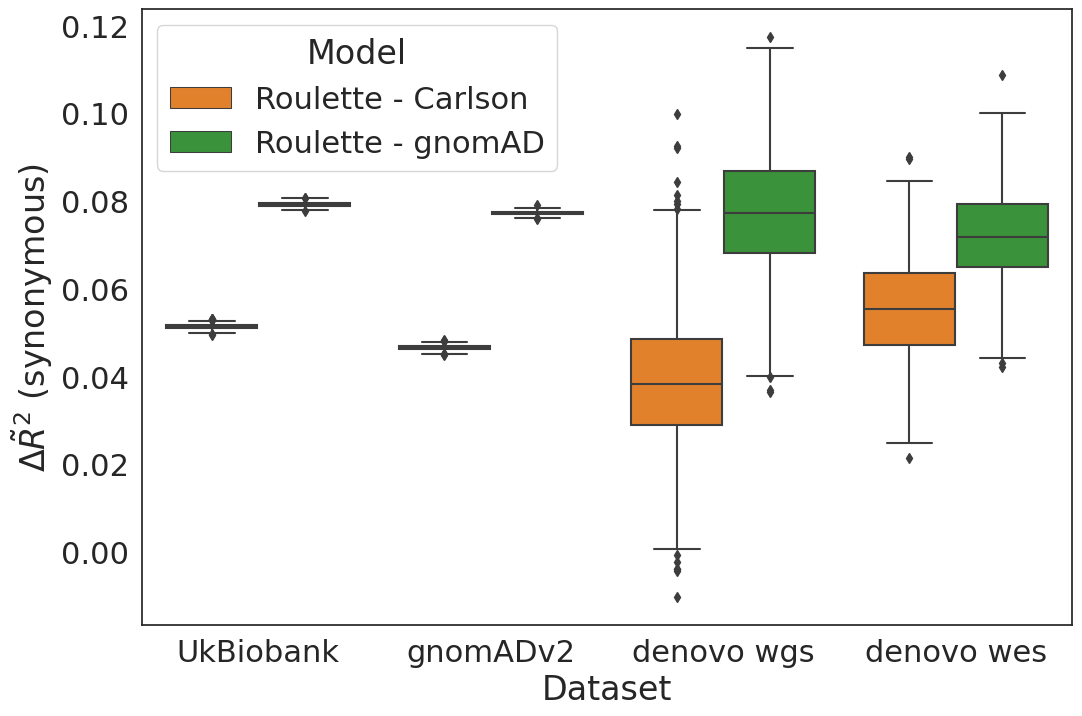

In [44]:
plt.subplots(figsize=(12, 8))

col = np.array(sns.color_palette())[1:]

ax = sns.boxplot(df_melt_combined, y="pR2 difference", x="Dataset", hue="Model", palette = col)

# ax.set_xlim(0.0, 0.07)
ax.set_ylabel(r"$\Delta \tilde{R}^2$ (synonymous)")